In [82]:
import networkx as nx
import pickle
import random
import scipy
from scipy.sparse import tril, find
import django
import sys, os
import pandas as pd
import matplotlib.pyplot as plt
import igraph
from django.core.management import call_command
from sklearn.preprocessing import PowerTransformer
import matplotlib
#matplotlib.rcParams['lines.markersize']**2*1.5

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.tasks import *

from django.db.models import Count, Sum

qid= 7979
q = Query.objects.get(pk=qid)

sample = 0

# You need to call the management command to generate the network, if this is a new query
regenerate_matrix = False
if regenerate_matrix:
    call_command('citation_matrix', qid)
    call_command('bib_matrix', qid, 0, "/home/galm/projects/anne-adaptation/citation_data")

Cmat = scipy.sparse.load_npz(f'citation_data/bibCouple_q_{qid}_{sample}.npz')

with open(f"citation_data/docnet_dict_q_{qid}_{sample}.pickle", "rb") as f:
    m_dict = pickle.load(f)
with open(f"citation_data/docnet_revdict_q_{qid}_{sample}.pickle", "rb") as f:
    rev_m_dict = pickle.load(f)
    
print(Cmat.shape, Cmat.nnz)
    
# We have a lot of connections! to make this more tractable, I ignore edges with fewer than x 
# references in common
Cmat.data *= Cmat.data>=5
Cmat.eliminate_zeros()

Cmat



(38541, 38541) 34043191


<38541x38541 sparse matrix of type '<class 'numpy.int64'>'
	with 464938 stored elements in Compressed Sparse Row format>

In [83]:


def check_cites(bc,rev_m_dict, i=0):
    d1 = Doc.objects.get(pk=rev_m_dict[bc[0][i]])
    d2 = Doc.objects.get(pk=rev_m_dict[bc[1][i]])
    print(bc[2][i])
    return set(d2.wosarticle.cr) & set(d1.wosarticle.cr)

bc = find(tril(Cmat,k=-1))

check_cites(bc, rev_m_dict, 1)



9


{'Aizen VB, 1996, J HYDROL, V186, P229, DOI 10.1016/S0022-1694(96)03022-3',
 'Akhtar M, 2008, J HYDROL, V355, P148, DOI 10.1016/j.jhydrol.2008.03.015',
 'Barnett TP, 2005, NATURE, V438, P303, DOI 10.1038/nature04141',
 'Hagg W, 2007, J HYDROL, V332, P40, DOI 10.1016/j.jhydrol.2006.06.021',
 'Hock R, 2003, J HYDROL, V282, P104, DOI 10.1016/S0022-1694(03)00257-9',
 'Horton P, 2006, HYDROL PROCESS, V20, P2091, DOI 10.1002/hyp.6197',
 'Konz M, 2010, J HYDROL, V385, P238, DOI 10.1016/j.jhydrol.2010.02.025',
 'Rees HG, 2006, HYDROL PROCESS, V20, P2157, DOI 10.1002/hyp.6209',
 'Stahl K, 2008, WATER RESOUR RES, V44, DOI 10.1029/2007WR005956'}

In [84]:

def read_network(Cmat, rev_m_dict, doc_ids=None):
    g = igraph.Graph()
    g.add_vertices(len(rev_m_dict))
    edges = []
    weights = []
    n1s, n2s, ews = find(tril(Cmat,k=-1))
    for i, n1 in enumerate(n1s):
        if doc_ids:
            if rev_m_dict[n1] not in doc_ids or rev_m_dict[n2s[i]] not in doc_ids:
                continue
        e = (n1,n2s[i])
        edges.append(e)
        weights.append(ews[i])
    g.add_edges(edges)
    g.es["weight"] = weights

    g.vs["doc_id"] = list(rev_m_dict.values())
    return g
    pass

g = read_network(Cmat, rev_m_dict, doc_ids)
print(g.summary())


IGRAPH U-W- 38541 213378 -- 
+ attr: doc_id (v), weight (e)


In [85]:
g.vs[1]

igraph.Vertex(<igraph.Graph object at 0x7f6cd16bd4f8>, 1, {'doc_id': 46})

In [97]:
g = g.clusters().giant()
print(g.summary())

IGRAPH U-W- 23337 212615 -- 
+ attr: doc_id (v), weight (e)


In [98]:
from fa2 import ForceAtlas2

forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,  # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=1,

    # Performance
    jitterTolerance=1.0,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,  # NOT IMPLEMENTED

    # Tuning
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=0.6,

    # Log
    verbose=True
)

positions = forceatlas2.forceatlas2_igraph_layout(
    g, pos=None, iterations=200, weight_attr="weight"
)


 78%|███████▊  | 155/200 [02:39<00:46,  1.03s/it]


100%|██████████| 200/200 [03:21<00:00,  1.01s/it]


BarnesHut Approximation  took  62.23  seconds
Repulsion forces  took  133.58  seconds
Gravitational forces  took  0.24  seconds
Attraction forces  took  1.62  seconds
AdjustSpeedAndApplyForces step  took  1.28  seconds


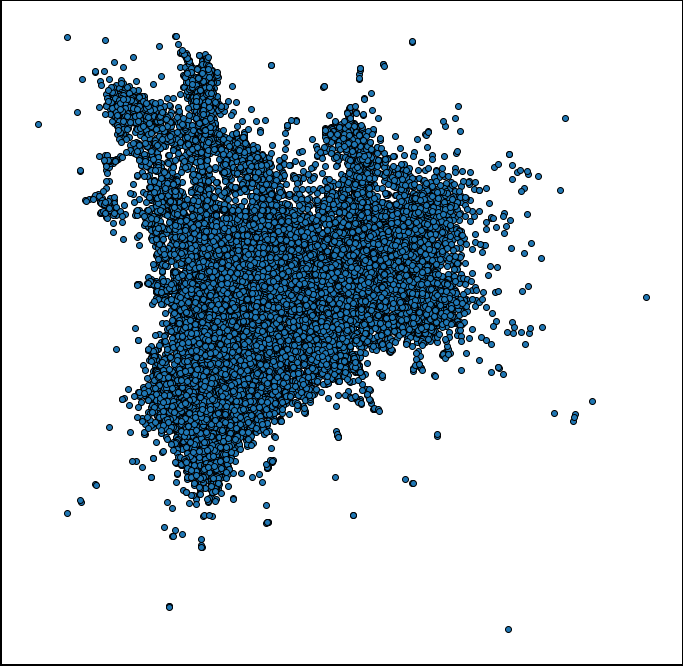

In [99]:
fig, ax = plt.subplots(figsize=(12,12),edgecolor="black",frameon=True,linewidth=4)

x,y = zip(*positions)

scatter = ax.scatter(x,y,edgecolor="black")

ax.grid(False)
ax.axis("off")

plt.show()

In [101]:
clusters = g.community_fastgreedy(weights="weight")
cl = clusters.as_clustering()
print(len(cl))

121


In [128]:
cl = clusters.as_clustering(n=10)

In [102]:
for v in g.vs:
    d = Doc.objects.get(pk=v["doc_id"])
    try:
        v["tc"] = int(d.wosarticle.tc)
    except:
        v["tc"] = 0
    
print(g.summary())

IGRAPH U-W- 23337 212615 -- 
+ attr: doc_id (v), tc (v), weight (e)


In [125]:
def summarise_cluster(cl, rev_m_dict, qs, c_threshold):
    ids = [g.vs[x]["doc_id"] for x in cl]
    docs = Doc.objects.filter(
        pk__in=ids,
        query__in=qs
    ).values('query__title').annotate(
        n=Count('pk')
    ).order_by('-n')
    df = pd.DataFrame.from_dict(list(docs))
    df['pc'] = round(df['n'] / df['n'].sum(),2)
    t = "\n".join([f"{r['query__title']} - {r['pc']:.0%}" for i,r in df.iterrows() if r['pc']>c_threshold])
    return t
                   
def summarise_category_cluster(cl, project, c_threshold):
    ids = [g.vs[x]["doc_id"] for x in cl]               
    dos = DocOwnership.objects.filter(
        doc__id__in=ids,
        query__project=project,
        relevant=1
    ).values('query__category__name').annotate(
        n = Count('pk')
    ).order_by('-n')
    df = pd.DataFrame.from_dict(list(dos))
    df['pc'] = round(df['n'] / df['n'].sum(),2)
    t = "\n".join([f"{r['query__category__name']} - {r['pc']:.0%}" for i,r in df.iterrows() if r['pc']>c_threshold])
    return t

def summarise_topic_cluster(cl, rev_m_dict, run_id, c_threshold):
    ids = [g.vs[x]["doc_id"] for x in cl]
    docs = Doc.objects.filter(
        pk__in=ids,
        doctopic__run_id=run_id,
        doctopic__score__gt=0.1
    ).values('doctopic__topic__title').annotate(
        n=Sum('doctopic__score')
    ).order_by('-n')
    df = pd.DataFrame.from_dict(list(docs))
    df['pc'] = round(df['n'] / df['n'].sum(),2)
    t = "\n".join([f"{r['doctopic__topic__title']} - {r['pc']:.0%}" for i,r in df.iterrows() if r['pc']>c_threshold])
    return t

In [153]:
def draw_network(ax, g, layout, labels, 
                 interactive=False, clusters=None, 
                 qs=None, min_c_size=0,
                 v_padding=50,
                 c_threshold=0.1, run_id=None,
                 rev_m_dict=None, pos="top",
                 category_sum=False,project=None,
                 hides=None, hide_thresh=None,
                 label_topcited_cluster=False
                ):
    #label_ids = [l['id'] for l in labels]
    cols = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc','#e5d8bd','#fddaec']
    
    palette = f"Set3_{len(clusters)}"
    import palettable.colorbrewer.qualitative as palettes

    try:
        cols = getattr(palettes, palette).hex_colors
    except:
        cols = palettes.Set3_12.hex_colors + palettes.Set3_12.hex_colors + palettes.Set3_12.hex_colors
                   
    ax.grid(False)
    ax.axis('off')
    ds = matplotlib.rcParams['lines.markersize']**2
    ls = [np.log([x+1 for x in g.vs["tc"]])]     
    pt = PowerTransformer()
    x = np.array([[x] for x in g.vs["tc"]])
    ts = pt.fit_transform(x)
    g.vs["sltc"] = [ds*0.6 + ds*x for x in ts] 
    
    x_offset=0
    if clusters:
        if rev_m_dict:
            pass

        if not hides:
            hides=rev_m_dict.values()
        else:
            ax.scatter(
                [],[],c=cols[0],alpha=1,label=f"pre {hide_thresh}",
                edgecolor="black",
                s=ds*2
            )
            ax.scatter(
                [],[],c=cols[0],alpha=0.5,label=f"post {hide_thresh}",
                edgecolor="black",
                s=ds*2
            )
            
        not_hides = set(hides) - set(rev_m_dict.values())
            

        # plot all points just to get the axis size
        x, y = zip(*layout)
        scatter = ax.scatter(
            x,y,edgecolor="black",
            c="none",
            s=0
        )      
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        xrange = xlim[1] - xlim[0]
        yrange = ylim[1] - ylim[0]
        x_step = xrange/3
        if pos=="top":
            ha = "center"
            x_offset = x_step/2
        else:
            ha="left"
            x_offset = xrange
        y_offset = 0
        
        # Go through each cluster and plot the points
        texts = []
        for i,c in enumerate(clusters):
            try:
                col = cols[i]
            except:
                col = "grey"
            for alpha, h in [(1,hides),(0.5, not_hides)]:
                try:
                    s, x, y = zip(*[
                        (g.vs[i]["sltc"],x[0],x[1]) \
                        for i,x in enumerate(layout) \
                        if i in c and g.vs[i]["doc_id"] in h
                    ])
                except ValueError:
                    continue
                    
                scatter = ax.scatter(
                    x,y,edgecolor="black", alpha=alpha,
                    c=col,
                    s=s
                )
                                
            if len(c) < min_c_size:
                continue
            if qs:
                t = summarise_cluster(c,rev_m_dict,qs,c_threshold)
            elif run_id:
                t = summarise_topic_cluster(c,rev_m_dict,run_id,c_threshold)
            elif category_sum:
                t = summarise_category_cluster(c, project, c_threshold)
            else:
                t = ""
                
            if label_topcited_cluster:
                tcs, ids, vs = zip(*[
                    (g.vs[i]["tc"], g.vs[i]["doc_id"], i) \
                    for i,x in enumerate(layout) \
                    if i in c
                ])
                tcs = np.array(tcs)
                tc = np.argsort(tcs)[-1]
                l = layout[vs[tc]]
                top_cited = Doc.objects.get(pk=ids[tc])
                ax.text(l[0],l[1],top_cited.title)
                
                               
            t = f"Cluster {i} - {len(c)} docs\n\n{t}"
            text = ax.text(
                    xlim[0]+x_offset,
                    ylim[1]+y_offset,
                    t,
                    bbox={'facecolor':col, 'alpha':0.5, 'pad':0.4, 'boxstyle': 'round'},
                    va="top",
                    ha=ha
                )
            texts.append(text)
            if pos=="top":
                x_offset+=x_step
                if xlim[0]+x_offset > xlim[1]:
                    fig.canvas.draw()
                    bs = []
                    for t in texts:
                        box = t.get_bbox_patch().get_window_extent()
                        tcbox = ax.transData.inverted().transform(box)
                        bs.append(tcbox[0][1])

                    y_offset+=min(bs)-ylim[1]
                    x_offset = x_step/2
            else:
                fig.canvas.draw()
                box = text.get_bbox_patch().get_window_extent()
                tcbox = ax.transData.inverted().transform(box)
                b = tcbox[0][1]

                y_offset=b-ylim[1] - v_padding           
            
        if hide_thresh:
            ax.legend(loc="lower center", ncol=2)
            #ax.text(cx, cy, "ASDFASDFASFD")
    else:
        x = [x[0] for x in layout]
        y = [x[1] for x in layout]
        scatter = ax.scatter(x,y,edgecolor="black")


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


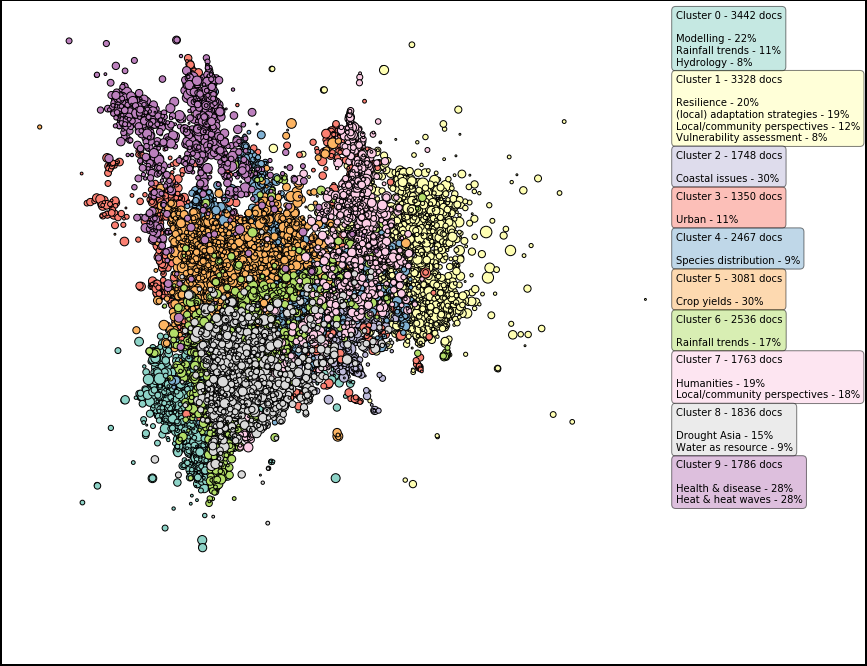

In [156]:
# Label the clusters by topic

fig, ax = plt.subplots(figsize=(12,12),edgecolor="black",frameon=True,linewidth=4)

draw_network(
    ax, g, positions, [], clusters=cl, 
    rev_m_dict=rev_m_dict, run_id=2704,
    min_c_size=500, # Only label clusters with more than this number of documents
    pos="right",
    c_threshold=0.07,
    v_padding=50,
    #label_topcited_cluster=True
)


plt.show()

In [140]:
tcs = np.array(g.vs['tc'])
np.argsort(tcs)[-1]

8841